# Práctico 3 - TSP

## Instalación de Dependencias
Instalación de dependencias requeridad para el experimento

In [12]:
# Install required packages
!pip install numpy matplotlib scipy

## Traveling Salesman Problem (TSP) Ejemplos

Este notebook utilizara matplot lib para ilustrar n ciudades y su solución

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.spatial.distance import pdist, squareform

## Genera un numero random de ciudades

In [14]:
np.random.seed(42)
num_cities = 6
cities = np.random.rand(num_cities, 2) * 100  # 2D coordinates (x, y)
city_labels = [f"Ciudad {i}" for i in range(num_cities)]

## Visualización de ciudades 

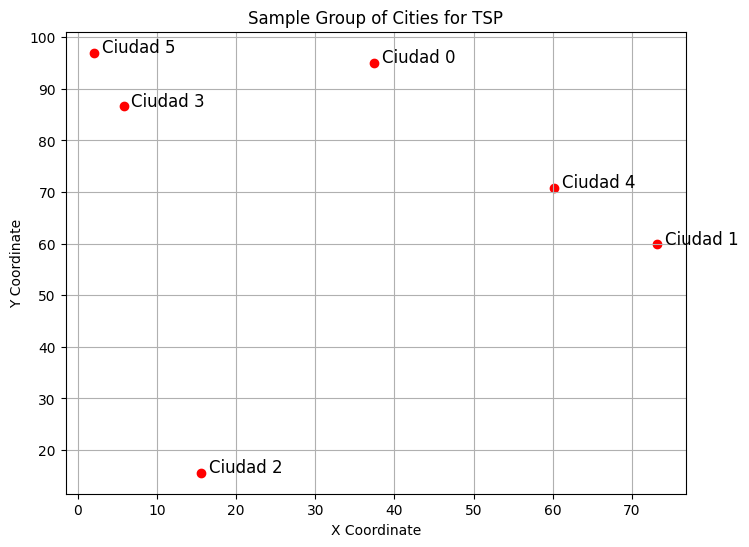

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y, city_labels[i], fontsize=12)
plt.title("Sample Group of Cities for TSP")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Algoritmos utilizados y helpers para su implementación

In [32]:
def route_length(route, cities):
    total = 0.0
    for i in range(len(route)):
        start = cities[route[i]]
        end = cities[route[(i+1)%len(route)]]
        total += np.linalg.norm(start - end)
    return total

In [17]:
from typing import List, Tuple, Dict

def brute_force(cities, num_cities,max_iterations: int = 10000) -> Tuple[float, List[int]]:
    routes = list(itertools.permutations(range(num_cities)))
    best_route = min(routes, key=lambda r: route_length(r, cities))
    best_length = route_length(best_route, cities)
    return best_length, best_route


In [34]:
import itertools
import random
import math
from typing import List, Tuple, Dict

class TSPHelper:
    """Helper methods for TSP algorithms.

    This class provides static methods for evaluating tour cost,
    generating neighbors, and reconstructing the optimal path.

    Methods:
        total_distance(tour, dist): Computes the cost of a tour.
        get_neighbors(tour): Generates all neighbors by pairwise swaps.
        random_neighbor(tour): Generates a neighbor by swapping two random cities.
        reconstruct_path(dp, n, last_city): Reconstructs the optimal route from DP table.
    """

    @staticmethod
    def total_distance(tour: List[int], dist: List[List[float]]) -> float:
        """Computes the total cost of a tour, returning to the start.

        Args:
            tour: List of city indices representing the tour.
            dist: 2D distance matrix.

        Returns:
            Total cost (float) of the tour including return to start.
        """
        return sum(dist[tour[i]][tour[(i + 1) % len(tour)]] for i in range(len(tour)))

    @staticmethod
    def get_neighbors(tour: List[int]) -> List[List[int]]:
        """Generates all neighbors of the tour by swapping any two cities.

        Args:
            tour: Current tour as a list of city indices.

        Returns:
            List of neighboring tours (each a list of city indices).
        """
        neighbors = []
        n = len(tour)
        for i in range(n):
            for j in range(i + 1, n):
                neighbor = tour.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(neighbor)
        return neighbors

    @staticmethod
    def random_neighbor(tour: List[int]) -> List[int]:
        """Generates a neighbor by randomly swapping two cities.

        Args:
            tour: Current tour as a list of city indices.

        Returns:
            Neighboring tour after a random swap.
        """
        a, b = random.sample(range(len(tour)), 2)
        neighbor = tour.copy()
        neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
        return neighbor

    @staticmethod
    def reconstruct_path(dp: Dict[Tuple[int, int], Tuple[float, int]], n: int, last_city: int) -> List[int]:
        """Reconstructs the optimal route from the Held-Karp DP table.

        Args:
            dp: DP table with (subset, last_city) as key and (cost, previous_city) as value.
            n: Number of cities.
            last_city: Last city visited before return to start.

        Returns:
            Optimal tour as a list of city indices (starting and ending at 0).
        """
        path = [0]
        bits = (1 << n) - 2  # All cities except start
        city = last_city
        for _ in range(n - 1):
            path.append(city)
            bits, prev_city = bits & ~(1 << city), dp[(bits, city)][1]
            city = prev_city
        path = path[::-1]
        return path

In [35]:
from scipy.spatial.distance import pdist, squareform

def hill_climbing(cities, num_cities):
    dist = squareform(pdist(cities))
    return hill_climbing_int(dist)

def simulated_annealing(cities, num_cities):
    dist = squareform(pdist(cities))
    return simulated_annealing_int(dist)

def hill_climbing_int(dist: List[List[float]], max_iterations: int = 10_000) -> Tuple[float, List[int]]:
    """Solves the TSP using Hill Climbing local search.

    Starts from a random tour and iteratively moves to the best neighbor
    found by swapping any two cities. Terminates when no improvement is possible.

    Args:
        dist: 2D matrix (n x n) of costs between cities.
        max_iterations: Maximum number of iterations.

    Returns:
        Tuple: (cost of best tour found, tour as list of city indices)
    """
    n = len(dist)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_cost = TSPHelper.total_distance(current_tour, dist)

    for _ in range(max_iterations):
        neighbors = TSPHelper.get_neighbors(current_tour)
        neighbor_costs = [TSPHelper.total_distance(neigh, dist) for neigh in neighbors]
        min_cost = min(neighbor_costs)
        if min_cost < current_cost:
            idx = neighbor_costs.index(min_cost)
            current_tour = neighbors[idx]
            current_cost = min_cost
        else:
            break  # Local minimum reached

    return current_cost, current_tour

def simulated_annealing_int(dist: List[List[float]], initial_temp: float = 1000.0,
                        cooling_rate: float = 0.995, max_iterations: int = 10_000) -> Tuple[float, List[int]]:
    """Solves the TSP using Simulated Annealing.

    Starts from a random tour and randomly samples neighbors (by swapping two cities).
    Moves to worse solutions with a probability that decreases with temperature.
    Can escape local minima to find better solutions.

    Args:
        dist: 2D matrix (n x n) of costs between cities.
        initial_temp: Starting temperature for annealing.
        cooling_rate: Rate at which the temperature decreases.
        max_iterations: Maximum number of iterations.

    Returns:
        Tuple: (cost of best tour found, tour as list of city indices)
    """
    n = len(dist)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_cost = TSPHelper.total_distance(current_tour, dist)
    best_tour = current_tour[:]
    best_cost = current_cost
    temp = initial_temp

    for _ in range(max_iterations):
        neighbor = TSPHelper.random_neighbor(current_tour)
        neighbor_cost = TSPHelper.total_distance(neighbor, dist)
        delta = neighbor_cost - current_cost
        # Accept neighbor if it improves cost or probabilistically if not
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_tour = neighbor
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_tour = current_tour[:]
                best_cost = current_cost
        temp *= cooling_rate
        if temp < 1e-8:
            break

    return best_cost, best_tour


## Helpers para ejecución de pruebas y graficos

In [36]:
def plot_complexity(city_counts, solve_times, algoritm):
    plt.figure(figsize=(8, 6))
    for i, n in enumerate(city_counts):
        plt.scatter(n, solve_times[i], color='blue')
        plt.text(n, solve_times[i], f"{solve_times[i]:.4g}s", fontsize=9, ha='left', va='bottom')
    plt.plot(city_counts, solve_times, marker='o', color='blue')
    plt.title(f"{algoritm.__name__} TSP Time Complexity vs Number of Cities (3 to {len(city_counts)+2})")
    plt.xlabel("Number of Cities")
    plt.ylabel("Computation Time (seconds)")
    plt.grid(True)
    plt.show()

In [37]:
# Defensive mechanism to avoid log(0) underflow for very small times
def plot_log_complexity(city_counts, solve_times,algoritm):
    log_times = [t if t > 0 else 1e-6 for t in solve_times]
    plt.figure(figsize=(8, 6))
    plt.plot(city_counts, log_times, marker='o', color='purple')
    for i, n in enumerate(city_counts):
        plt.text(n, log_times[i], f"{solve_times[i]:.4g}s", fontsize=9, ha='left', va='bottom')
    plt.yscale('log')
    plt.title(f"{algoritm.__name__} TSP Computation Time (Log Scale) vs Number of Cities (3 to {len(city_counts)+2})")
    plt.xlabel("Number of Cities")
    plt.ylabel("Computation Time (seconds, log scale)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [22]:
import time

def run_n_cities(algorithm, max_cities=6, show_plots=True):
    np.random.seed(42)
    initial_cities = np.random.rand(3, 2) * 100
    cities = initial_cities.copy()
    city_labels = [f"City {i}" for i in range(3)]
    solve_times = []
    best_costs = []
    city_counts = list(range(3, max_cities + 1))
    print(city_counts)
    result_rows = []  # (n, route_str, best_length_str, elapsed_str)

    algo_name = getattr(algorithm, "__name__", "algorithm")

    # Sólo preparamos objetos de figura/axes si realmente vamos a plotear
    if show_plots:
        fig = None
        axes = None
        slot_idx = 0
        slots_in_fig = 0

    for i, n in enumerate(city_counts):
        if n > 3:
            # Add one new city
            new_city = np.random.rand(1, 2) * 100
            cities = np.vstack([cities, new_city])
            city_labels.append(f"City {n-1}")

        start_time = time.time()
        best_length, best_route = algorithm(cities, n)
        elapsed = time.time() - start_time

        solve_times.append(elapsed)
        best_costs.append(best_length)

        # progreso corto por problema
        print(f"[{i+1}/{len(city_counts)}] ciudades={n} | tiempo={elapsed:.4f}s | costo={best_length:.2f}")

        # ----------- PLOTEO (opcional) -----------
        if show_plots:
            # subplots de a 3
            if slot_idx == 0:
                remaining = min(3, len(city_counts) - i)
                fig, axes = plt.subplots(1, remaining, figsize=(6 * remaining, 5))
                if remaining == 1:
                    axes = [axes]  # normaliza a lista
                slots_in_fig = remaining

            ax = axes[slot_idx]
            slot_idx += 1

            # puntos y labels
            ax.scatter(cities[:, 0], cities[:, 1])
            for j, (x, y) in enumerate(cities):
                ax.text(x + 1, y + 1, city_labels[j], fontsize=9)

            # ruta
            route_cities = np.array([cities[k] for k in best_route] + [cities[best_route[0]]])
            ax.plot(route_cities[:, 0], route_cities[:, 1], marker='o')

            ax.set_title(f"[{algo_name}] TSP {n} | Costo {best_length:.2f}\nTiempo {elapsed:.4f}s")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.grid(True)

            # si llenamos la fila (3) o es el último, mostrar y resetear
            if slot_idx == slots_in_fig or i == len(city_counts) - 1:
                plt.tight_layout()
                plt.show()
                slot_idx = 0  # listo para la próxima figura
        # ----------- FIN PLOTEO -----------

        # guardar para la tabla final
        route_str = "->".join(map(str, best_route))
        result_rows.append((n, route_str, f"{best_length:.2f}", f"{elapsed:.4f}"))

    # --- tabla final: n | ruta | largo | tiempo(s) ---
    headers = ["n", "ruta", "largo", "tiempo(s)"]
    col_widths = [
        max(len(str(h)), *(len(str(r[c])) for r in result_rows))
        for c, h in enumerate(headers)
    ]

    def fmt_row(row):
        return " | ".join(str(val).ljust(col_widths[c]) for c, val in enumerate(row))

    sep = "-+-".join("-" * w for w in col_widths)

    print("\n" + fmt_row(headers))
    print(sep)
    for row in result_rows:
        print(fmt_row(row))

    # gráficos de complejidad sólo si se pidió plotear
    if show_plots:
        plot_complexity(city_counts, solve_times, algorithm)        # agrega título dentro con algo_name si querés
        plot_log_complexity(city_counts, solve_times, algorithm)

    return city_counts, solve_times, best_costs

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # para ticks enteros

def plot_algorithms_times_costs(algorithms, max_cities, start_at=3):
    """
    algorithms: lista de funciones [alg1, alg2, ...]
    max_cities: se pasa directo a run_n_cities(...)
    run_n_cities: callable (algorithm, max_cities, show_plots=False) -> (city_counts, solve_times, best_costs)
    start_at: mínimo de ciudades a graficar (por defecto 3)
    """
    series = []  # [(label, x, times, costs), ...]

    for alg in algorithms:
        city_counts, solve_times, best_costs = run_n_cities(alg, max_cities, show_plots=False)

        # filtrar desde start_at
        idxs = [i for i, n in enumerate(city_counts) if n >= start_at]
        x = [city_counts[i] for i in idxs]
        t = [int(solve_times[i]) if float(solve_times[i]).is_integer() else float(solve_times[i]) for i in idxs]
        c = [int(best_costs[i]) if float(best_costs[i]).is_integer() else float(best_costs[i]) for i in idxs]

        label = getattr(alg, "__name__", str(alg))
        series.append((label, x, t, c))

    # --- graficar ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax_time, ax_cost = axes

    for label, x, t, c in series:
        ax_time.plot(x, t, marker='o', label=label)
        ax_cost.plot(x, c, marker='o', label=label)

    # subplot tiempos
    ax_time.set_title("Tiempo (log) vs. Nº de ciudades")
    ax_time.set_xlabel("Ciudades (n)")
    ax_time.set_ylabel("Tiempo (s)")
    ax_time.set_yscale("log")
    ax_time.xaxis.set_major_locator(MaxNLocator(integer=True))  # ticks enteros
    ax_time.grid(True)
    ax_time.legend()

    # subplot costos
    ax_cost.set_title("Costo vs. Nº de ciudades")
    ax_cost.set_xlabel("Ciudades (n)")
    ax_cost.set_ylabel("Costo de la ruta")
    ax_cost.xaxis.set_major_locator(MaxNLocator(integer=True))  # ticks enteros
    ax_cost.grid(True)
    ax_cost.legend()

    plt.tight_layout()
    plt.show()
    return series



## Algoritmo de Brute-Force  para un numero pequeño de ciudades

In [24]:
best_length, best_route = brute_force(cities, num_cities)
print("Best route:", best_route)
print("Best route length: {:.2f}".format(best_length))

Best route: (0, 4, 1, 2, 3, 5)
Best route length: 241.07


### Representación grafica de Brute-Force

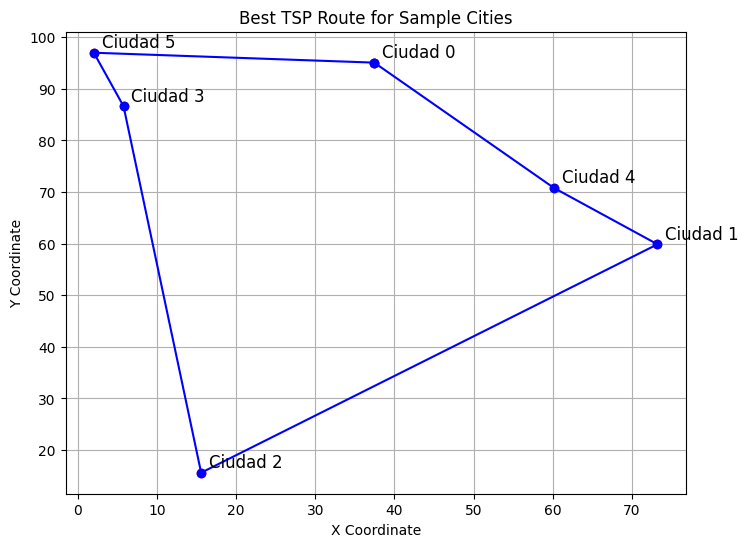

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)

# Draw the route
route_cities = np.array([cities[i] for i in best_route] + [cities[best_route[0]]])
plt.plot(route_cities[:, 0], route_cities[:, 1], 'b-o')

plt.title("Best TSP Route for Sample Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

### Ruta random de TSP para comparación

Random route: [4 2 0 5 1 3]
Random route length: 398.09


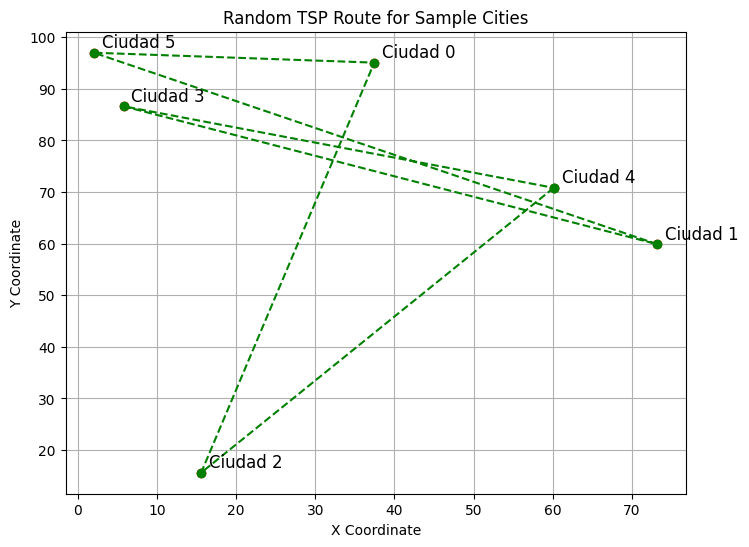

In [26]:
random_route = np.random.permutation(num_cities)
random_length = route_length(random_route, cities)

print("Random route:", random_route)
print("Random route length: {:.2f}".format(random_length))

plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)

route_cities = np.array([cities[i] for i in random_route] + [cities[random_route[0]]])
plt.plot(route_cities[:, 0], route_cities[:, 1], 'g--o')
plt.title("Random TSP Route for Sample Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Solución y Visualización del Algoritmo TSP para un Número Incremental de Ciudades

Esta sección calcula la solución del algoritmo TSP para entre 3 y n ciudades, agregando una ciudad a la vez al conjunto existente, y visualiza la ruta óptima junto con el tiempo y el costo para cada caso.

[3, 4, 5, 6]
[1/4] ciudades=3 | tiempo=0.0004s | costo=205.24
[2/4] ciudades=4 | tiempo=0.0009s | costo=227.26
[3/4] ciudades=5 | tiempo=0.0068s | costo=227.35


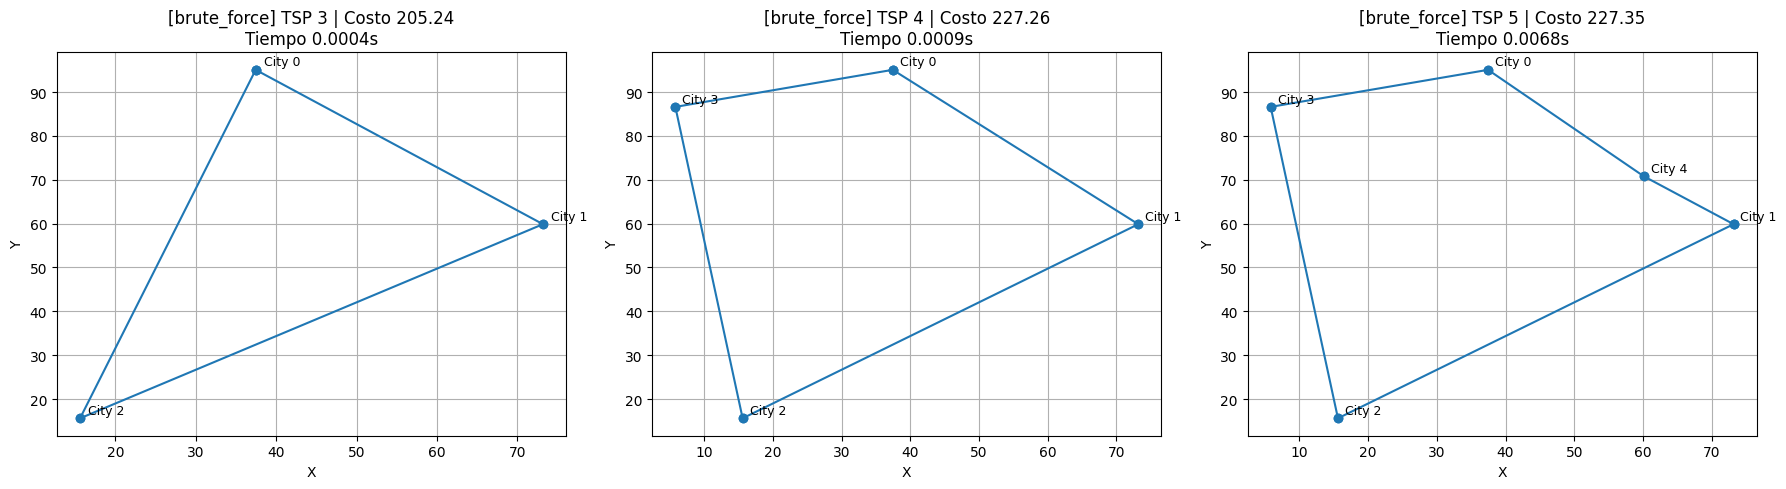

[4/4] ciudades=6 | tiempo=0.0528s | costo=241.07


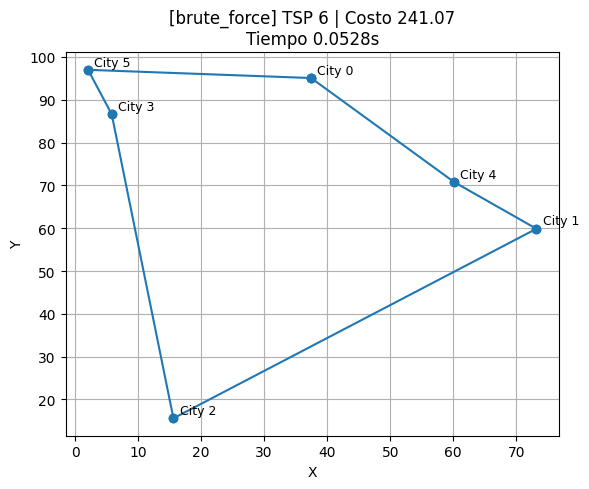


n | ruta             | largo  | tiempo(s)
--+------------------+--------+----------
3 | 0->1->2          | 205.24 | 0.0004   
4 | 0->1->2->3       | 227.26 | 0.0009   
5 | 1->4->0->3->2    | 227.35 | 0.0068   
6 | 0->4->1->2->3->5 | 241.07 | 0.0528   


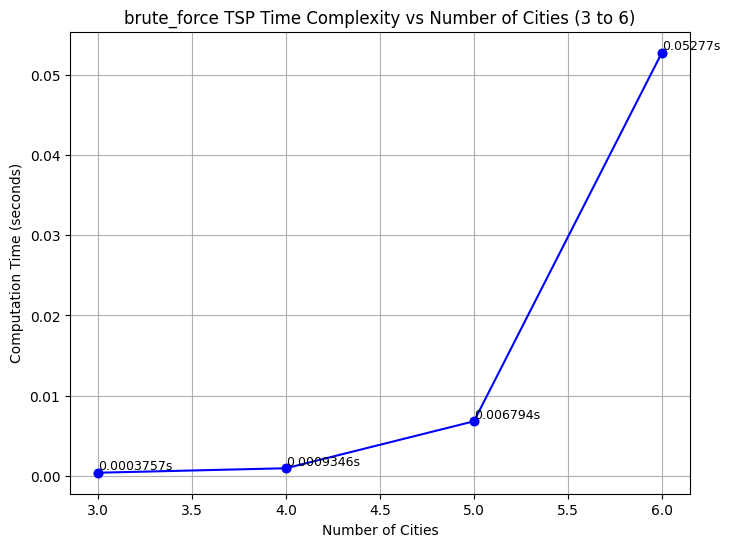

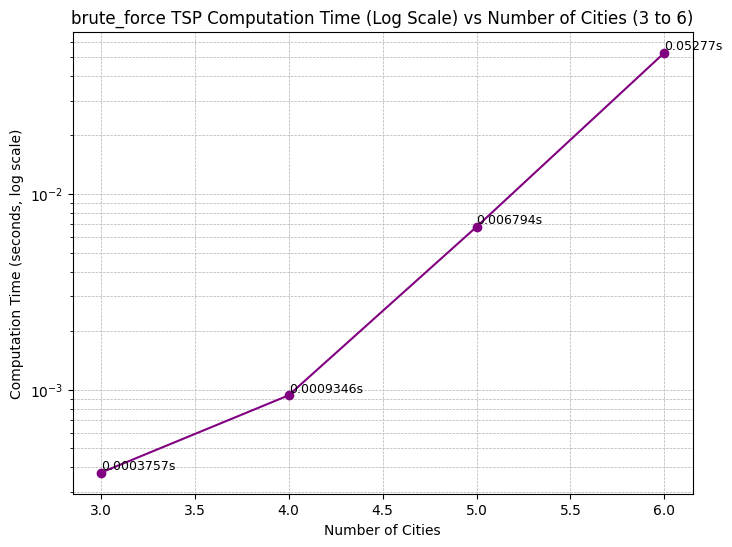

In [39]:
np.random.seed(42)

import time
algorithm=brute_force
max_cities = 6
city_counts, solve_times,_ = run_n_cities(algorithm, max_cities)


## Ejercicio 1 - Held Karp
- Implemente la función de `held_karp_dist(dist)` la cual recibe como entrada una matriz de distancias y realice almenos la ejecución de 20 ciudades para su comparación
- Compare los resultados obtenidos con brute-force, tanto en tiempo como en calidad de la solución . Ambas son las mejores? si es asi justifique porque ocurre esto.

In [41]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

def held_karp(cities, num_cities):
    dist = squareform(pdist(cities))
    return held_karp_dist(dist)

def held_karp_dist(dist: List[List[float]]) -> Tuple[float, List[int]]:
    """Solves the TSP using Held-Karp Dynamic Programming algorithm.

    This is an exact algorithm with O(n^2 * 2^n) time and space complexity.
    Suitable only for small n (n <= 20).

    Args:
        dist: 2D matrix (n x n) of costs between cities.

    Returns:
        Tuple: (minimum tour cost, tour as list of city indices)
    """
    path = cities = list(range(len(dist)))
    min_cost = 1.0
    n = len(dist)

    # g[S][k] = costo mínimo de ir de 0 a k pasando por todos en S
    # Usamos un diccionario: clave (frozenset(S), k)
    g = {}

    # Caso base: conjuntos de tamaño 1
    for k in range(1, n):
        g[(frozenset([k]), k)] = dist[0][k]

    # Construcción por tamaño de subconjunto
    for s in range(2, n):
        for S in combinations(range(1, n), s):
            S = frozenset(S)
            for k in S:
                prev_S = S - {k}
                g[(S, k)] = min(
                    g[(prev_S, m)] + dist[m][k] for m in prev_S
                )

    # Cierre del ciclo
    all_nodes = frozenset(range(1, n))
    opt_cost, last_node = min(
        (g[(all_nodes, k)] + dist[k][0], k) for k in range(1, n)
    )

    # Reconstrucción del camino
    tour = [0]
    S = all_nodes
    k = last_node
    while S:
        tour.append(k)
        prev_S = S - {k}
        # buscamos de dónde vino k
        k = min(prev_S, key=lambda m: g[(prev_S, m)] + dist[m][tour[-1]]) if prev_S else 0
        S = prev_S
    tour.append(0)

    return opt_cost, tour


[3, 4, 5, 6, 7, 8, 9]
[1/7] ciudades=3 | tiempo=0.0004s | costo=205.24
[2/7] ciudades=4 | tiempo=0.0003s | costo=227.26
[3/7] ciudades=5 | tiempo=0.0004s | costo=227.35


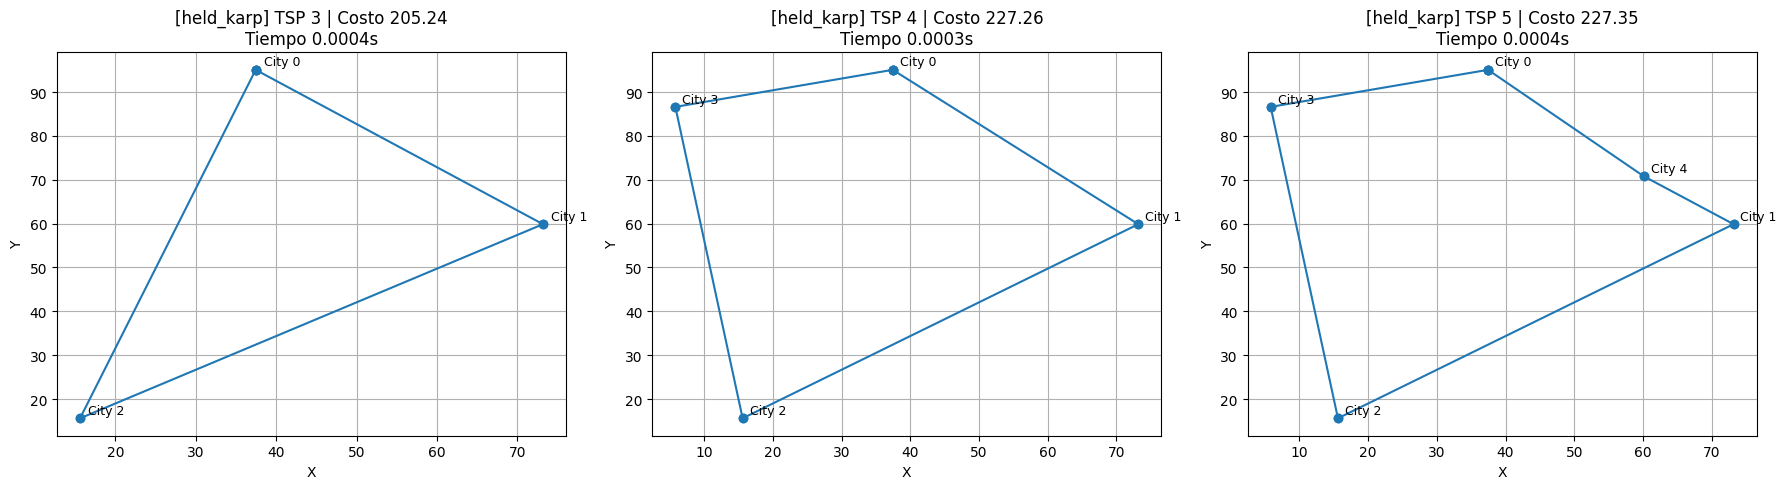

[4/7] ciudades=6 | tiempo=0.0006s | costo=241.07
[5/7] ciudades=7 | tiempo=0.0259s | costo=276.22
[6/7] ciudades=8 | tiempo=0.0049s | costo=277.23


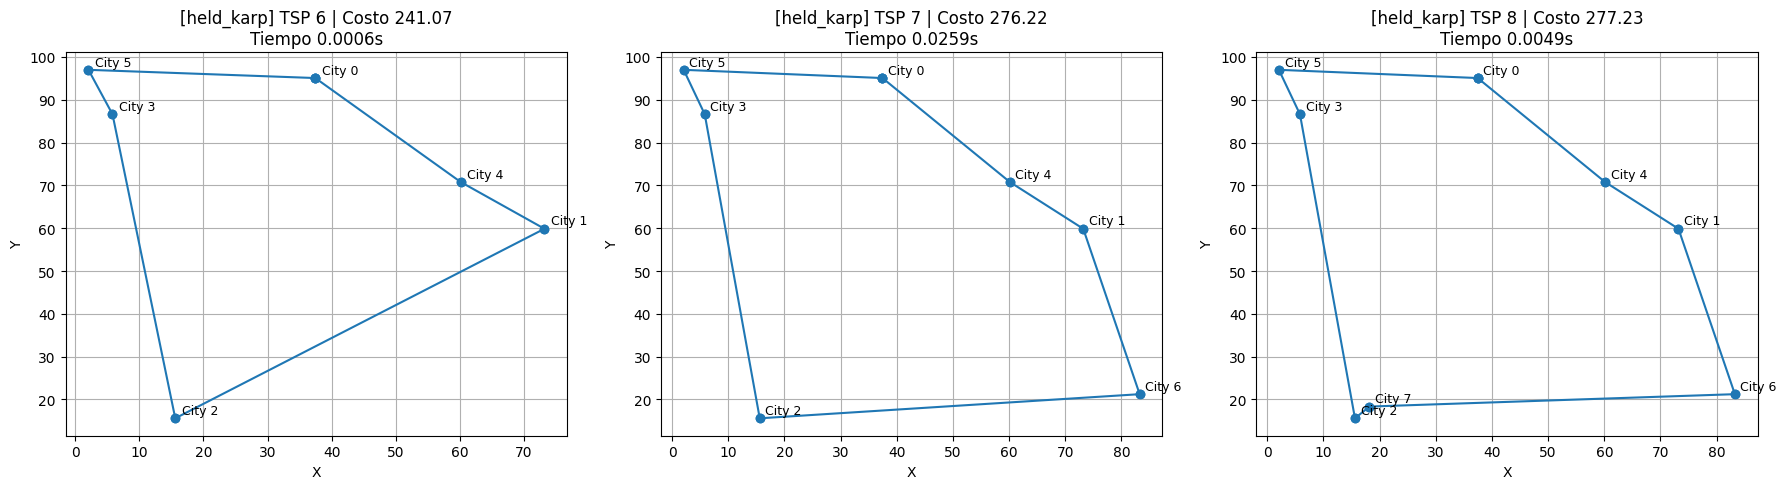

[7/7] ciudades=9 | tiempo=0.0146s | costo=286.65


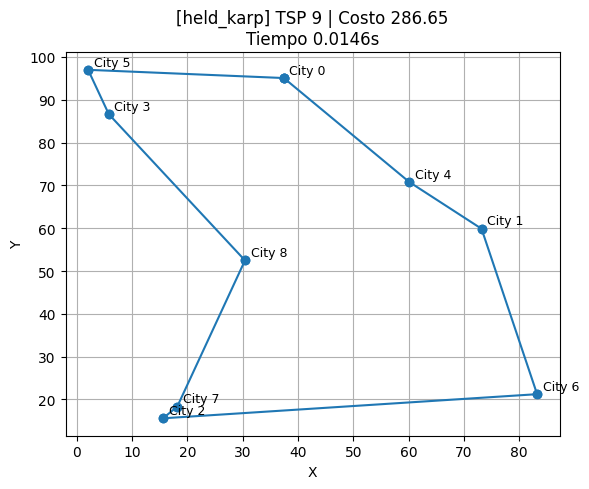


n | ruta                         | largo  | tiempo(s)
--+------------------------------+--------+----------
3 | 0->2->1->0                   | 205.24 | 0.0004   
4 | 0->1->2->3->0                | 227.26 | 0.0003   
5 | 0->3->2->1->4->0             | 227.35 | 0.0004   
6 | 0->5->3->2->1->4->0          | 241.07 | 0.0006   
7 | 0->4->1->6->2->3->5->0       | 276.22 | 0.0259   
8 | 0->4->1->6->7->2->3->5->0    | 277.23 | 0.0049   
9 | 0->4->1->6->2->7->8->3->5->0 | 286.65 | 0.0146   


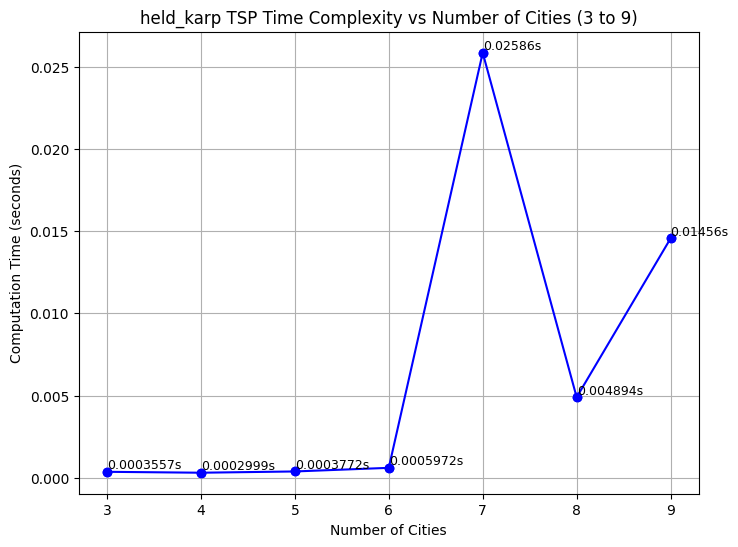

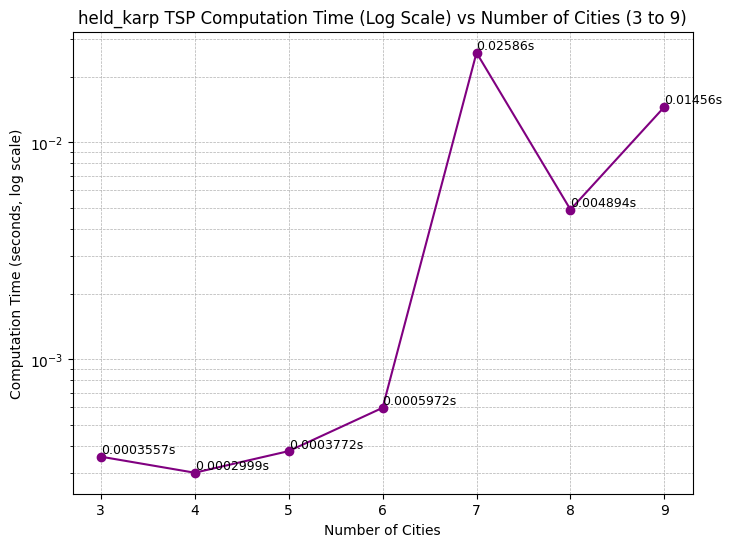

[3, 4, 5, 6, 7, 8, 9] [0.00035572052001953125, 0.0002999305725097656, 0.0003771781921386719, 0.0005972385406494141, 0.025864362716674805, 0.0048944950103759766, 0.014562845230102539] [np.float64(205.23579819680498), np.float64(227.25986949326284), np.float64(227.34551867849092), np.float64(241.06807549059883), np.float64(276.21833744551475), np.float64(277.23241951682456), np.float64(286.6472235549413)]
[3, 4, 5, 6, 7, 8, 9]
[1/7] ciudades=3 | tiempo=0.0004s | costo=205.24
[2/7] ciudades=4 | tiempo=0.0018s | costo=227.26
[3/7] ciudades=5 | tiempo=0.0052s | costo=227.35
[4/7] ciudades=6 | tiempo=0.0497s | costo=241.07
[5/7] ciudades=7 | tiempo=0.3911s | costo=276.22
[6/7] ciudades=8 | tiempo=3.0533s | costo=277.23
[7/7] ciudades=9 | tiempo=30.3334s | costo=286.65

n | ruta                      | largo  | tiempo(s)
--+---------------------------+--------+----------
3 | 0->1->2                   | 205.24 | 0.0004   
4 | 0->1->2->3                | 227.26 | 0.0018   
5 | 1->4->0->3->2     

In [45]:
np.random.seed(42)

import time
algorithm=held_karp
max_cities = 9 
city_counts, solve_times, best_costs = run_n_cities(algorithm, max_cities, show_plots=True)
print(city_counts, solve_times, best_costs)

# Ejecutar brute-force para el mismo rango de ciudades
algorithm = brute_force
bf_city_counts, bf_solve_times, bf_best_costs = run_n_cities(algorithm, max_cities, show_plots=False)

# Comparación de tiempos y costos
print("\nComparación Held-Karp vs Brute-Force (hasta n=10):")
print("n | Held-Karp costo | Brute-Force costo | Held-Karp t(s) | Brute-Force t(s)")
print("-" * 65)
for n, hk_cost, bf_cost, hk_time, bf_time in zip(city_counts, best_costs, bf_best_costs, solve_times, bf_solve_times):
    print(f"{n:<2}| {hk_cost:.2f}{' ' * (15-len(f'{hk_cost:.2f}'))}| {bf_cost:.2f}{' ' * (17-len(f'{bf_cost:.2f}'))}| {hk_time:.5f}{' ' * (15-len(f'{hk_time:.5f}'))}| {bf_time:.5f}")

print("\nJustificación:")
print(
    "Ambos algoritmos (Held-Karp y Brute-Force) encuentran la solución óptima para el TSP, "
    "ya que exploran todas las posibles rutas (brute-force por enumeración explícita y Held-Karp por programación dinámica). "
    "Sin embargo, Held-Karp es mucho más eficiente en tiempo y memoria para n moderados (hasta ~20), "
    "mientras que brute-force se vuelve rápidamente inviable a medida que n crece, debido a su complejidad factorial. "
    "Por eso, los costos de ruta son iguales, pero los tiempos de ejecución de Held-Karp son mucho menores para n > 7."
)

## Tarea 2 - Comparación metaheuristicas con held-kap
Realice el experiemento con held-karp y utilice los algoritmos de hill_climbing y simulated anneling en comparación.
- Cual es la diferencia empirica en el tiempo de ejecución.
- Todos los caminos encontrados resuelven el problema? Si es asi, todas las soluciones son óptimas? Justifique
- En caso de no ser optimas las soluciones realice un grafico demostrando la diferencia de costo por optimizar no optimizado. es decir la distancia entre el optimo y la distancia en la solución algoritmica. 

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[1/13] ciudades=3 | tiempo=0.0004s | costo=205.24
[2/13] ciudades=4 | tiempo=0.0003s | costo=227.26
[3/13] ciudades=5 | tiempo=0.0007s | costo=227.35
[4/13] ciudades=6 | tiempo=0.0011s | costo=241.07
[5/13] ciudades=7 | tiempo=0.0018s | costo=276.22
[6/13] ciudades=8 | tiempo=0.0040s | costo=277.23
[7/13] ciudades=9 | tiempo=0.0079s | costo=286.65
[8/13] ciudades=10 | tiempo=0.0276s | costo=290.31
[9/13] ciudades=11 | tiempo=0.0492s | costo=296.25
[10/13] ciudades=12 | tiempo=0.1095s | costo=297.25
[11/13] ciudades=13 | tiempo=0.2544s | costo=298.93
[12/13] ciudades=14 | tiempo=0.5962s | costo=305.29
[13/13] ciudades=15 | tiempo=1.4551s | costo=320.53

n  | ruta                                                | largo  | tiempo(s)
---+-----------------------------------------------------+--------+----------
3  | 0->2->1->0                                          | 205.24 | 0.0004   
4  | 0->1->2->3->0                                       | 

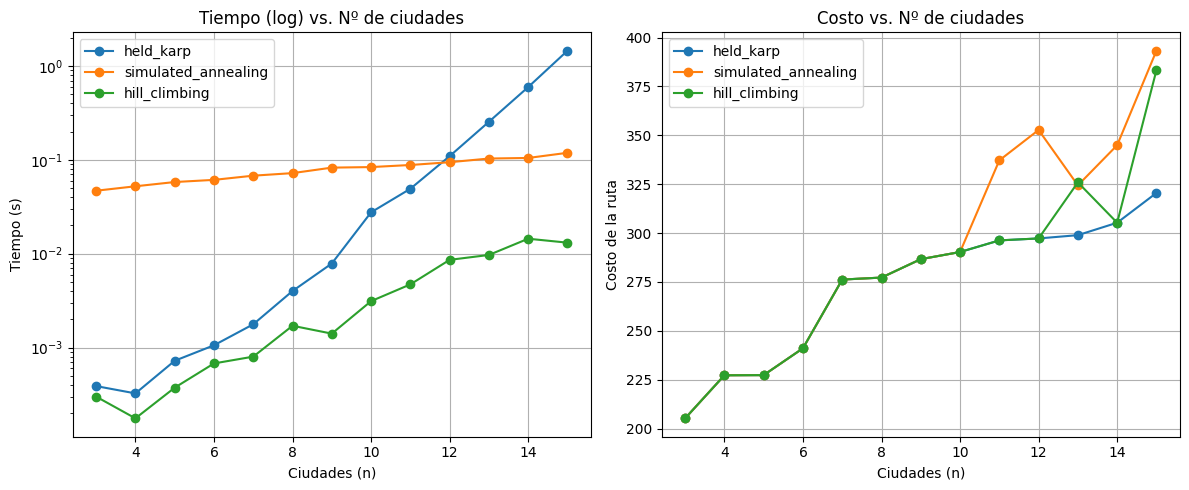

In [46]:
algs = [held_karp, simulated_annealing, hill_climbing]
series = plot_algorithms_times_costs(algs, max_cities=15) ##A efectos practico se recomienda bajar a n=20 ya que esto podria demorar mucho 